![](https://www.dii.uchile.cl/wp-content/uploads/2021/06/Magi%CC%81ster-en-Ciencia-de-Datos.png)


# Proyecto: Riesgo en el Banco Giturra

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

### Cuerpo Docente:

- Profesor: Pablo Badilla, Ignacio Meza De La Jara
- Auxiliar: Sebastián Tinoco
- Ayudante: Diego Cortez M., Felipe Arias T.
- Alumno: Germán Urrea


---


### Instalación de Librerías y Carga de Datos.


Para el desarrollo de su proyecto, utilice el conjunto de datos `dataset.pq` para entrenar un modelo de su elección. Además, se adjunta junto con los datos del proyecto un archivo llamado `requirements.txt` que contiene todas las bibliotecas y versiones necesarias para el desarrollo del proyecto. Se le recomienda levantar un ambiente de `conda` para instalar estas librerías y así evitar cualquier problema con las versiones.


In [1]:
!pip install joblib==1.3.1
!pip install lightgbm==4.0.0
!pip install numpy==1.23
!pip install --upgrade pandas "dask[complete]"
!pip install python-dateutil==2.8.2
!pip install pytz==2023.3
!pip install scikit-learn==1.2.2
!pip install scipy==1.11.1
!pip install six==1.16.0
!pip install threadpoolctl==3.2.0
!pip install tzdata==2023.3
!pip install xgboost==1.7.6
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 3.3.5
    Uninstalling lightgbm-3.3.5:
      Successfully uninstalled lightgbm-3.3.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 37.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.5/985.5 kB 66.2 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
  Attempting uninstall: dask
    Found existing installation: dask 2022.12.1
    Uninstalling dask-2022.12.1:
      Successfully uninstalled dask-2022.12.1
  Attempting uninstall: distributed
    Found existing installation: distributed 2022.12.1


### 1. Introducción


El banquero Giturra requiere de un modelo de predicción de riesgos de préstamo, de forma que pueda ofrecerle mejores condiciones a los clientes que presenten un menor riesgo. Los datos disponibles para esta tarea se componen principalmente de el historial de comportamiento financiero del cliente, como el número de prestamos, comportamiento de pago de créditos, salario mensual, etc.

En este caso se enfocará el problema en predecir a aquellos clientes que supongan un riesgo para el banquero, pues priorizando la predicción de riesgos altos se podrá evitar mejor el impago de prestamos. Es debido a lo anterior que se le dará prioridad a la métrica F1 en el caso de riesgo alto, pues dado que además se busca la retención de clientes responsables, es prudente tener un equilibrio entre encontrar a los clientes riesgosos y no acusar falsamente a un cliente de riesgoso.

Con el objetivo de resolver el problema se preprocesan los datos, reemplazando outliers, creando características nuevas, codificando características categoricas, escalando características numéricas y aplicando técnicas de balanceo de clases. Para el modelamiento se aplican multiples clasificadores, así como técnicas de ajuste de hiperparámetros. Al finalizar los experimentos el mejor clasificador obtenido no logra una métrica F1 alta, sin embargo esta es suficientemente alta para demostrar que es posible encontrar relaciones útiles para resolver el problema y seguir iterando para mejorar los resultados.

### 2. Carga de datos Análisis Exploratorio de Datos


In [1]:
import pandas as pd
df = pd.read_parquet('dataset.pq')

### 3. Preparación de Datos


#### Limpieza de datos

Durante la exploración de datos se identificaron algunos patrones que podrían complicar la tarea de clasificación:
- Variables númericas como `age` poseen valores extremos que no tienen mucho sentido en su contexto. Otras variables como `annual_income` poseen valores extremos, pero si pueden tener sentido (por ejemplo, el banco podría tener clientes millonarios).
- A su vez, variables categoricas como `payment_behaviour` o `occupation` poseen valores sin sentido o en blanco.

Es debido a esto que antes de preprocesar los datos se considerarán los valores extemos como nulos, con el objetivo de reemplazarlos posteriormente, mientras que muestras con variables categoricas sin sentido simplemente se eliminarán.

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
import numpy as np

In [3]:
import re
def preprocess_payment_behaviour(s):
    match = re.match(r'(\w+_spent)_(\w+.+)', s)
    return match.group(1), match.group(2)

In [12]:
def clean_df(df, clean_na= True, clean_outliers = True):
  df_copy = df.copy(True)
  # Limpiar
  # Outliers válidos: annual_income,
  # Negativos validos:  changed_credit_limit
  # Negativos no válidos: age, monthly_balance (principalmente porque es muy extremo)
  # Negativos a cambiar por 0: Delay_from_due_date, Num_of_Delayed_Payment, Num_of_Loan

  # Eliminar/Reemplazar valores extraños
  df_copy = df_copy[df_copy['payment_behaviour']!='!@9#%8']
  df_copy = df_copy.replace({'_______': 'Not specified'})

  # Eliminar negativos que no hacen sentido
  no_negatives = ['age', 'monthly_balance']
  if clean_outliers:
    df_copy = df_copy[(df_copy[no_negatives] < 0 ).any(axis=1)]
  else:
    df_copy.loc[:, no_negatives] = np.where(df_copy[no_negatives] < 0, np.nan, df_copy[no_negatives])
  # Reemplazar negativos que podrían ser interpretados como zero
  num = df_copy._get_numeric_data().drop(columns = ['changed_credit_limit'])
  if clean_outliers:
      num[num < 0] = 0
  else:
      num[num<0] = np.nan
  # No pueden haber rangos de edades extraños
  if clean_outliers:
    df_copy = df_copy[(df_copy['age']<100)]
  else:
    df_copy.loc[df_copy['age'] >= 100, 'age'] = np.nan

  # Quitar valores extremos que no hacen sentido
  no_outliers = ['num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan',
                 'num_of_delayed_payment', 'num_credit_inquiries']
  outliers_thresh = df_copy[no_outliers].quantile(0.95)
  if clean_outliers:
    df_copy = df_copy[(df_copy[no_outliers]<=outliers_thresh).any(axis=1)]
  else:
    # np.where(df[no_outliers] > df[no_outliers].quantile(0.95) , np.nan, df[no_outliers])
    df_copy.loc[:, no_outliers] = np.where(df_copy[no_outliers] > df_copy[no_outliers].quantile(0.95) , np.nan, df_copy[no_outliers])


  # Feature Engineering
  df_copy[['spent', 'payment_value']] = df_copy['payment_behaviour'].apply(preprocess_payment_behaviour).apply(pd.Series)
  if clean_na:
    df_copy = df_copy.dropna()
  return df_copy



#### Preprocesamiento

Como preprocesamiento previo al modelamiento se realizará lo siguiente:
- Eliminar el id de cliente, pues no aporta a la generalización
- Imputar NANS númericos como la mediana de la distribución
- Aplicar RobustScaler a las variables númericas, pues existen variables con outliers, por lo que este tipo de escalado es más adecuado.
- Aplicar encoders a variables categoricas, aquellas que puedan ordenarse serán codificadas con un ordinal encoder, mientras que aquellas que no se codificarán con un one hot encoder.

Se crearán, además, variables categoricas en base a otras:
- Se separará la edad en rangos.
- Se separará la variable `payment_behaviour` entre los gastos y el valor de los pagos, de forma que puedan ordenarse.

En cuanto a los valores nulos, la eliminación de estos implicaría la eliminación de casi 2000 muestras de un número inicial de 12500. Este número no es menor, y se considera que se podrían aprovechar los datos que si están bien imputados si se reemplazan dichos valores nulos, en este caso, debido a la presencia de outliers, se utilizará como medida de imputación la mediana, que es una medida con cierta robustez hacia valores extremos.

In [13]:
df_cleaned = clean_df(df, clean_na=False, clean_outliers=False)
df_cleaned[['num_bank_accounts', 'num_credit_card', 'interest_rate', 'num_of_loan',
                 'num_of_delayed_payment', 'num_credit_inquiries']].max()

num_bank_accounts         10.0
num_credit_card           10.0
interest_rate             33.0
num_of_loan                8.0
num_of_delayed_payment    24.0
num_credit_inquiries      14.0
dtype: float64

In [20]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

spent_ordinal = OrdinalEncoder(categories = [['Low_spent', 'High_spent']])
payment_ordinal = OrdinalEncoder(categories = [['Small_value_payments', 'Medium_value_payments', 'Large_value_payments']])
age_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('to_ordinal', KBinsDiscretizer(encode='ordinal', random_state=42))
    ])
scaling_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [21]:
num_cols = df_cleaned._get_numeric_data().drop(columns = ['credit_score', 'age']).columns
ct = ColumnTransformer(
    [
        ("drop", "drop", ["customer_id", "payment_behaviour"]),
        ("encoding", OneHotEncoder(sparse_output=False), ['occupation', 'payment_of_min_amount']),
        ("num_preprocess", scaling_pipe, num_cols),
        ("spent_encoding", spent_ordinal, ['spent']),
        ("payment_encoding", payment_ordinal, ['payment_value']),
        ("age_group", age_pipe, ['age'])
         ],
     remainder='passthrough', sparse_threshold=0, verbose_feature_names_out=False)

In [22]:
ct.set_output(transform="pandas")
df_trans = ct.fit_transform(df_cleaned)
ct.set_output(transform="default")

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('drop', 'drop',
                                 ['customer_id', 'payment_behaviour']),
                                ('encoding', OneHotEncoder(sparse_output=False),
                                 ['occupation', 'payment_of_min_amount']),
                                ('num_preprocess',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('RobustScaler',
                                                  RobustScaler())]),
                                 Index(['annual_income',...
                                                             'High_spent']]),
                                 ['spent']),
                                ('payment_encoding',
                                 OrdinalEncoder(categories=[['Small_value_payments',
                                                             'Medium_value_payments',
                                                             'Large_value_payments']]),
                                 ['payment_value']),
                                ('age_group',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('to_ordinal',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   random_state=42))]),
                                 ['age'])],
                  verbose_feature_names_out=False)

In [96]:
df_trans.head()

,occupation_Accountant,occupation_Architect,occupation_Developer,occupation_Doctor,occupation_Engineer,occupation_Entrepreneur,occupation_Journalist,occupation_Lawyer,occupation_Manager,occupation_Mechanic,...,outstanding_debt,credit_utilization_ratio,credit_history_age,total_emi_per_month,amount_invested_monthly,monthly_balance,spent,payment_value,age,credit_score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.259903,-0.987422,0.000000,-0.165160,-0.625574,0.098383,1.0,1.0,1.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.408305,0.063621,0.818182,-0.387448,0.487616,0.087668,0.0,0.0,1.0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.097093,0.699019,0.000000,1.261541,56.578008,2.912448,1.0,0.0,2.0,0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.388443,-0.590513,-0.090909,-0.404798,-0.047346,0.208837,1.0,0.0,4.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.162963,-0.762135,1.181818,-0.523430,0.272148,0.129153,1.0,0.0,0.0,0


Por último, se considerará un split estándar 80:20 entre conjuntos de entrenamiento y prueba.

In [25]:
x, y = df_cleaned.drop(columns=['credit_score']), df_cleaned['credit_score']

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

### 4. Baseline

Como primera aproximación se modela el problema con una variedad de clasificadores, teniendo todos estos como datos de entrada el conjunto de entrenamiento con el preprocesamiento descrito anteriormente.
Los clasificadores a probar son los siguientes, todos utilizando los parámetros por defecto de sklearn:
- Dummy estratificado
- Regresión logistica
- KNN
- Árbol de decisión
- SVM
- Random Forest
- LGBM
- XGBoost

Se calculan las métricas Precision, Recall y F1 para cada uno de estos, así como el tiempo de entrenamiento.

In [28]:
np.random.seed(42)

In [27]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [40]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from time import time
rs = 42
clfs = [DummyClassifier(strategy='stratified'), LogisticRegression(random_state=rs),
        KNeighborsClassifier(), DecisionTreeClassifier(random_state=rs),
        SVC(random_state=rs), RandomForestClassifier(random_state=rs),
        LGBMClassifier(random_state=rs), XGBClassifier(random_state=rs)]

base_metrics = {'Recall':{}, 'Precision':{}, "F1":{}, 'Time':{}}
for clf in clfs:
  pipe = Pipeline([
      ('ct', ct),
      ('clf', clf)
  ])
  clf_name = str(type(clf).__name__)
  ti = time()
  pipe.fit(x_train, y_train)
  train_time = time()-ti
  y_pred = pipe.predict(x_test)

  base_metrics['Recall'][clf_name] = recall_score(y_test, y_pred, zero_division=0.0)
  base_metrics['Precision'][clf_name]= precision_score(y_test, y_pred, zero_division=0.0)
  base_metrics['F1'][clf_name]= f1_score(y_test, y_pred, zero_division=0.0)
  base_metrics['Time'][clf_name]= train_time
  print(f'Performance: {clf_name}')
  print(classification_report(y_test, y_pred, zero_division=0.0))

Performance: DummyClassifier
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      1612
           1       0.29      0.27      0.28       689

    accuracy                           0.58      2301
   macro avg       0.49      0.49      0.49      2301
weighted avg       0.57      0.58      0.58      2301



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Performance: LogisticRegression
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1612
           1       0.63      0.41      0.50       689

    accuracy                           0.75      2301
   macro avg       0.71      0.65      0.67      2301
weighted avg       0.74      0.75      0.73      2301

Performance: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.78      0.88      0.82      1612
           1       0.59      0.41      0.49       689

    accuracy                           0.74      2301
   macro avg       0.68      0.65      0.66      2301
weighted avg       0.72      0.74      0.72      2301

Performance: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1612
           1       0.48      0.46      0.47       689

    accuracy                           0.69      2301
   macro avg       0.62   

In [98]:
metrics_df = pd.DataFrame(base_metrics)
metrics_df.sort_values(by='F1', ascending=False)

,Recall,Precision,F1,Time
RandomForestClassifier,0.516691,0.698039,0.593828,2.745048
LGBMClassifier,0.529753,0.667276,0.590615,0.353003
XGBClassifier,0.489115,0.656920,0.560732,2.766191
LogisticRegression,0.409289,0.630872,0.496479,0.448340
KNeighborsClassifier,0.413643,0.590062,0.486348,0.544618
DecisionTreeClassifier,0.460087,0.475976,0.467897,0.431083
DummyClassifier,0.268505,0.285935,0.276946,0.132481
SVC,0.000000,0.000000,0.000000,6.789562


En general todos los clasificadores, con la excepción de SVC, el cual está sesgado hacia la clase mayoritaria, logran mejores métricas que el clasificador Dummy. En este caso, tanto Random Forest como LightGBM presentan las métricas F1 más altas, siendo muy cercanas entre sí. En general, los clasificadores basados en ensamblaje presentan los mejores resultados, esto puede deberse a la combinación de clasificadores debiles, lo que crea un clasficador final más robusto y capaz de capturar posibles relaciones no lineales entre variables.



In [101]:
metrics_df.sort_values(by='Time')

,Recall,Precision,F1,Time
DummyClassifier,0.268505,0.285935,0.276946,0.132481
LGBMClassifier,0.529753,0.667276,0.590615,0.353003
DecisionTreeClassifier,0.460087,0.475976,0.467897,0.431083
LogisticRegression,0.409289,0.630872,0.496479,0.448340
KNeighborsClassifier,0.413643,0.590062,0.486348,0.544618
RandomForestClassifier,0.516691,0.698039,0.593828,2.745048
XGBClassifier,0.489115,0.656920,0.560732,2.766191
SVC,0.000000,0.000000,0.000000,6.789562


En cuanto al tiempo de entrenamiento, el clasificador LGBM es de los más eficientes, a diferencia de Random Forest, el cuál toma un tiempo significativamente mayor. En este sentido, se considera que, tomando en cuenta tanto tiempo de ejecución como métricas, es conveniente experimentar con los clasificadores LGBM y Regresión logistica, debido a que, si bien no poseen la métrica F1 más alta, son los clasificadores con mayor potencial para el ajuste de hiperparámetros, pues obtienen métricas relativamente altas, a la vez que sus tiempos de ejecución son de los más pequeños.

### 5. Optimización del Modelo
Debido a que los clasificadores LGBM y regresión logística logran un buen equilibrio entre eficiencia en el tiempo de entrenamiento y métrica F1, se opta por experimentar con el reajuste de hiperparámetros de estos, con el objetivo de mejorar la métrica objetivo.

Para esto se aplica el mismo preprocesado utilizado en la sección anterior, con la adición de oversampling en la clase minoritaria  mediante la técnica SMOTE, con el objetivo de mejorar los modelos al eliminar el desbalance de clases en el entrenamiento.


In [42]:
!pip install optuna

In [57]:
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution
from optuna.distributions import IntDistribution
from optuna.distributions import FloatDistribution
from optuna import create_study

#### Ajuste de LGBM

Para el reajuste de hiperparámetros del clasificador LGBM, se experimenta con los siguientes:
- Algoritmo de boosting: GBDT, DART
- Número de estimadores: 50, 100, 150
- Learning rate: 0.05, 0.1, 0.15

In [106]:
lg_pipe = Pipeline([
    ('ct', ct),
    ('smote', SMOTE()),
    ('clf', LGBMClassifier(random_state=rs))
], memory=".")

lg_params = {'clf__boosting_type':CategoricalDistribution(['gbdt', 'dart']),
           'clf__n_estimators':IntDistribution(50, 150, step=50),#([50, 100, 150]),
             'clf__learning_rate': FloatDistribution(0.05, 0.15, step=0.05)#[0.05, 0.1, 0.15]
             }
lg_study = create_study(direction='maximize')
lg_grid = OptunaSearchCV(lg_pipe, lg_params, n_jobs=4, scoring='f1', study=lg_study)
lg_grid.fit(x_train, y_train)

[I 2023-07-23 05:51:07,336] A new study created in memory with name: no-name-564dda3e-4aa0-43ae-bb80-166a00df5eb6
<ipython-input-106-0a3defa686ce>:12: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2023-07-23 05:51:22,483] Trial 1 finished with value: 0.6187000248197784 and parameters: {'clf__boosting_type': 'gbdt', 'clf__n_estimators': 50, 'clf__learning_rate': 0.05}. Best is trial 1 with value: 0.6187000248197784.
[I 2023-07-23 05:51:22,652] Trial 3 finished with value: 0.6187000248197784 and parameters: {'clf__boosting_type': 'gbdt', 'clf__n_estimators': 50, 'clf__learning_rate': 0.05}. Best is trial 1 with value: 0.6187000248197784.
[I 2023-07-23 05:51:28,745] Trial 2 finished with value: 0.5924147323469301 and parameters: {'clf__boosting_type': 'gbdt', 'clf__n_estimators': 100, 'clf__learning_rate': 0.1}. Best is trial 1 with value: 0.6187000248197784.
[I 2023-07-23 05:51:51,451] Trial 4 finished with valu

[LightGBM] [Info] Number of positive: 6577, number of negative: 6577
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9498
[LightGBM] [Info] Number of data points in the train set: 13154, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


OptunaSearchCV(estimator=Pipeline(memory='.',
                                  steps=[('ct',
                                          ColumnTransformer(remainder='passthrough',
                                                            sparse_threshold=0,
                                                            transformers=[('drop',
                                                                           'drop',
                                                                           ['customer_id',
                                                                            'payment_behaviour']),
                                                                          ('encoding',
                                                                           OneHotEncoder(sparse_output=False),
                                                                           ['occupation',
                                                                            'payment_of_min_amount']),
                                                                          ('num_preprocess',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='median'))...
                                          LGBMClassifier(random_state=42))]),
               n_jobs=4,
               param_distributions={'clf__boosting_type': CategoricalDistribution(choices=('gbdt', 'dart')),
                                    'clf__learning_rate': FloatDistribution(high=0.15, log=False, low=0.05, step=0.05),
                                    'clf__n_estimators': IntDistribution(high=150, log=False, low=50, step=50)},
               scoring='f1',
               study=<optuna.study.study.Study object at 0x7a23296f5600>)

In [113]:
print('Mejores Hiperparámetros')
print(lg_grid.best_params_)

Mejores Hiperparámetros
{'clf__boosting_type': 'gbdt', 'clf__n_estimators': 50, 'clf__learning_rate': 0.05}
Resultado en conjunto de entrenamiento
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      6577
           1       0.64      0.66      0.65      2624

    accuracy                           0.80      9201
   macro avg       0.75      0.76      0.76      9201
weighted avg       0.80      0.80      0.80      9201



El mejor clasificador LGBM utiliza el algoritmo GBDT, utiliza 50 estimadores y tiene un learning rate de 0.05. Se visualiza la importancia de los hiperparámetros así como la relación entre estos.

In [108]:
from optuna.visualization import plot_param_importances
fig = plot_param_importances(lg_study)
fig.show()

In [111]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_rank
fig = plot_rank(lg_study)
fig.show()

<ipython-input-111-04d1ce20d018>:3: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



En general, variaciones en el algoritmo de boosting o el número de estimadores no parecen tener un impacto significativo o consistente, mientras que el uso de un learning rate más pequeño fue lo que gatilló mejores resultados.

#### Ajuste de regresión logistica

En el caso de la regresión logística, se ajustan los siguientes hiperparámetros:
- Penalización: L1, L2
- C: 0.5, 1, 1.5

In [ ]:
logit_pipe = Pipeline([
    ('ct', ct),
    ('smote', SMOTE()),
    ('clf', LogisticRegression(random_state=rs, n_jobs=4, solver='saga', max_iter=150)) #KNeighborsClassifier(n_jobs=4)
], memory=".")

logit_params = {
    'clf__penalty':CategoricalDistribution(['l1', 'l2']),
    'clf__C': FloatDistribution(0.5, 1.5, step=0.5)
}
logit_study = create_study(direction='maximize')
logit_grid = OptunaSearchCV(logit_pipe, logit_params, n_jobs=4, scoring='f1', study=logit_study)
logit_grid.fit(x_train, y_train)

In [117]:
print('Mejores Hiperparámetros')
print(logit_grid.best_params_)


{'clf__penalty': 'l1', 'clf__C': 0.5}
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      6577
           1       0.55      0.69      0.61      2624

    accuracy                           0.75      9201
   macro avg       0.70      0.73      0.71      9201
weighted avg       0.77      0.75      0.76      9201



El mejor algoritmo de regresión logística utiliza penalización L1 y utiliza un C igual a 0.5. Una vez realizado el entrenamiento en grilla, se visualiza la importancia de hiperparámetros, así como la relación entre estos.

In [115]:
fig = plot_param_importances(logit_study)
fig.show()

In [116]:
fig = plot_rank(logit_study)
fig.show()

<ipython-input-116-f6203ebe5eac>:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



En este caso, el tipo de penalización no toma tanto peso, aunque la penalización de tipo L1 da resultados ligeramente mejores. Por otro lado, el parámetro más relevante es el coeficiente de regularización C, siendo una regularización baja más estricta y, en este caso, mejorando el rendimiento del modelo.

#### Mejor clasificador

Se prueban los mejores clasificadores de cada tipo con el conjunto de entrenamiento, siendo el mejor de estos el clasificador LGBM, con una métrica F1 más alta en la clase positiva, al mismo tiempo que obtiene un mejor rendimiento en la clase negativa.

In [118]:
print('Resultado en conjunto de entrenamiento (LGBM)')
print(classification_report(y_train, lg_grid.predict(x_train)))
print('Resultado en conjunto de entrenamiento (Logistic)')
print(classification_report(y_train, logit_grid.predict(x_train)))

Resultado en conjunto de entrenamiento (LGBM)
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      6577
           1       0.64      0.66      0.65      2624

    accuracy                           0.80      9201
   macro avg       0.75      0.76      0.76      9201
weighted avg       0.80      0.80      0.80      9201

Resultado en conjunto de entrenamiento (Logistic)
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      6577
           1       0.55      0.69      0.61      2624

    accuracy                           0.75      9201
   macro avg       0.70      0.73      0.71      9201
weighted avg       0.77      0.75      0.76      9201



Se prueba el mejor clasificador en el conjunto de prueba, obteniendo mejor F1 que cualquiera de los clasificadores probados en el baseline.

In [119]:
print('Resultado en conjunto de prueba')
print(classification_report(y_test, lg_grid.predict(x_test)))

Resultado en conjunto de prueba
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1612
           1       0.63      0.62      0.63       689

    accuracy                           0.78      2301
   macro avg       0.73      0.73      0.73      2301
weighted avg       0.78      0.78      0.78      2301



In [39]:
best_clf = lg_grid.best_estimator_

### 6. Interpretabilidad

- Analizar 10 observaciones aleatorias utilizando un método específico para verificar la coherencia de las interacciones entre las características. R: Waterfall plot
- Explorar cómo se relacionan las variables utilizando algún descriptivo de interpretabilidad. R: ?


Es fundamental que los estudiantes sean capaces de determinar si su modelo toma decisiones coherentes y evaluar el impacto que podría tener la aplicación de un modelo con esas variables en una población. ¿Es posible que el modelo sea perjudicial o que las estimaciones se basen en decisiones sesgadas?

En resumen, esta sección busca que los estudiantes apliquen un enfoque crítico para evaluar la interpretabilidad de su modelo, identificar posibles sesgos y analizar las implicaciones de sus decisiones en la población objetivo.

Una vez obtenido el mejor clasificador, se considera prudente interpretar los resultados del modelo. Dado que el banquero Giturra necesita resultados fáciles de interpretar, y que se está ante un problema de clasificación binaria, se opta por utilizar SHAP values para la interpretación de resultados, debido a la facilidad que estos dan para saber como influyen las caracteristicas en la decisión del modelo.

In [120]:
import shap

In [121]:
# Obtener x con preprocesado
ct.set_output(transform="pandas")
x_trans = ct.fit_transform(x_train)
ct.set_output(transform='default')

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('drop', 'drop',
                                 ['customer_id', 'payment_behaviour']),
                                ('encoding', OneHotEncoder(sparse_output=False),
                                 ['occupation', 'payment_of_min_amount']),
                                ('num_preprocess',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('RobustScaler',
                                                  RobustScaler())]),
                                 Index(['annual_income',...
                                                             'High_spent']]),
                                 ['spent']),
                                ('payment_encoding',
                                 OrdinalEncoder(categories=[['Small_value_payments',
                                                             'Medium_value_payments',
                                                             'Large_value_payments']]),
                                 ['payment_value']),
                                ('age_group',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('to_ordinal',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   random_state=42))]),
                                 ['age'])],
                  verbose_feature_names_out=False)

In [122]:
explainer = shap.TreeExplainer(best_clf.named_steps['clf'])
shap_values = explainer.shap_values(x_trans)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### Resultados generales

Se empieza por un análisis general de los shap values en la clase positiva mediante un gráfico resumen de barra, en el que las características se ordenan por importancia. Entre las características más importantes se tienen `outstanding_debt` (deuda por pagar ), `interest_rate` (interés) y `num_credit_card` (Numero de tarjetas de credito), estas 3 características, en particular `outstanding_debt`, son las que más peso tienen en el modelo por diferencia, mientras que el resto de características en comparación no tienen tanto peso en el output final.

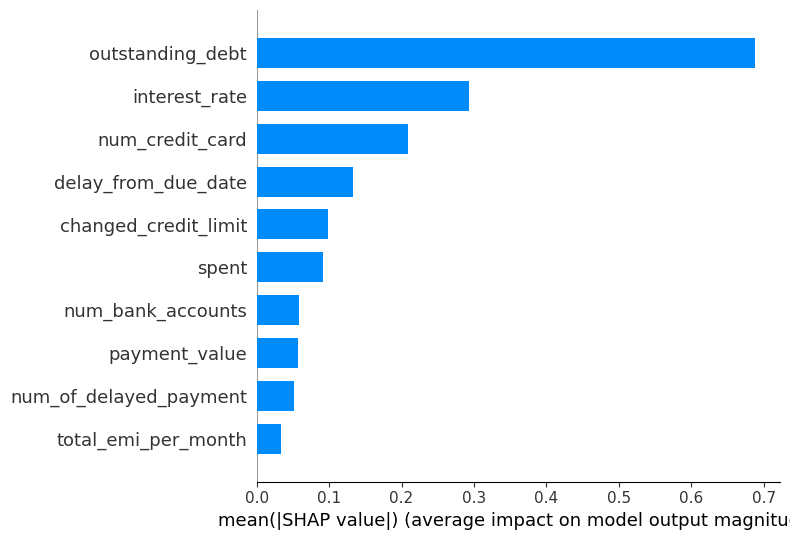

In [127]:
shap.summary_plot(shap_values[1], x_trans, plot_type='bar', max_display=10)

Para estudiar más a fondo el comportamiento de las características, se visualiza en un gráfico de densidad la relación entre el valor de las características con el output final. En este se puede notar que, por ejemplo, valores más altos de `outstanding_debt` se asocian a una predicción positiva de riesgo alto, esto tiene sentido pues un cliente con una mayor deuda es más probable que tenga problemas para pagar o necesite más tiempo para ello. En general, una mayor cantidad de factores de riesgo como un interés alto en la tarjeta de crédito o un número alto de estas, se asocian con un riesgo alto de no pago.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


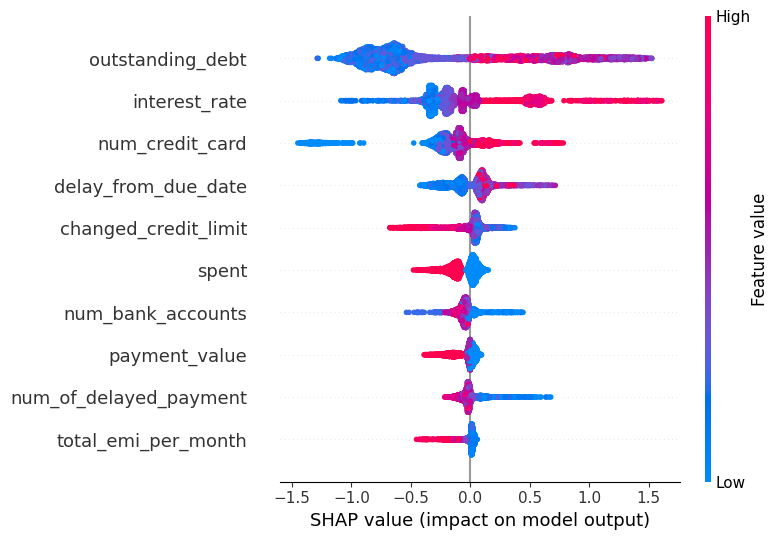

In [ ]:
shap.summary_plot(shap_values[1], x_trans, plot_type='dot', max_display=10)

In [128]:
def shapley_feature_ranking(shap_values, X):
    feature_order = np.argsort(np.mean(np.abs(shap_values), axis=0))
    return pd.DataFrame(
        {
            "features": [X.columns[i] for i in feature_order][::-1],
            "importance": [
                np.mean(np.abs(shap_values), axis=0)[i] for i in feature_order
            ][::-1],
        }
    )

In [131]:
feature_importance_df = shapley_feature_ranking(shap_values[1], x_trans)

Siguiendo la línea del análisis general se busca determinar cuales son las características menos importantes, para ello se calculan las importancias en el caso de la clase positiva, esta se calcula como el promedio del valor absoluto de los shap values. Del calculo se determina que las características menos relevantes incluyen a todas aquellas asociadas a la profesión del cliente, con importancias muy cercanas a 0, por lo que apenas influyen en el modelo. Estos resultados no son del todo extraños, pues si bien la profesión podría ser un indicio del estatus economico del cliente, en la realidad existen muchas profesiones, por lo que podrían no traducirse bien a nivel de generalización.

In [134]:
least_important = feature_importance_df.sort_values(by=['importance']).head(10)
least_important

,features,importance
37,occupation_Journalist,0.000000
36,occupation_Media_Manager,0.000000
35,occupation_Doctor,0.000448
34,occupation_Lawyer,0.001551
33,occupation_Scientist,0.001848
32,occupation_Teacher,0.001881
31,occupation_Not specified,0.002266
30,occupation_Engineer,0.002529
29,occupation_Architect,0.002801
28,occupation_Accountant,0.003245


#### Resultados locales

In [137]:
 # Replicabilidad
 np.random.seed(42)
 samples = np.random.randint(0, len(x_trans), size = 10)

Para realizar un estudio más localizado del impacto en el modelo, se revisan los shap values de 10 muestras aleatorias mediante un heatmap. Del heatmap se puede desprender que, efectivamente, la variable `outstanding_debt` tiene un gran peso en el output del modelo, dado que en general posee los shap values más marcados y cuyo signo (positivo o negativo) suelen determinar el output esperado de la muestra.

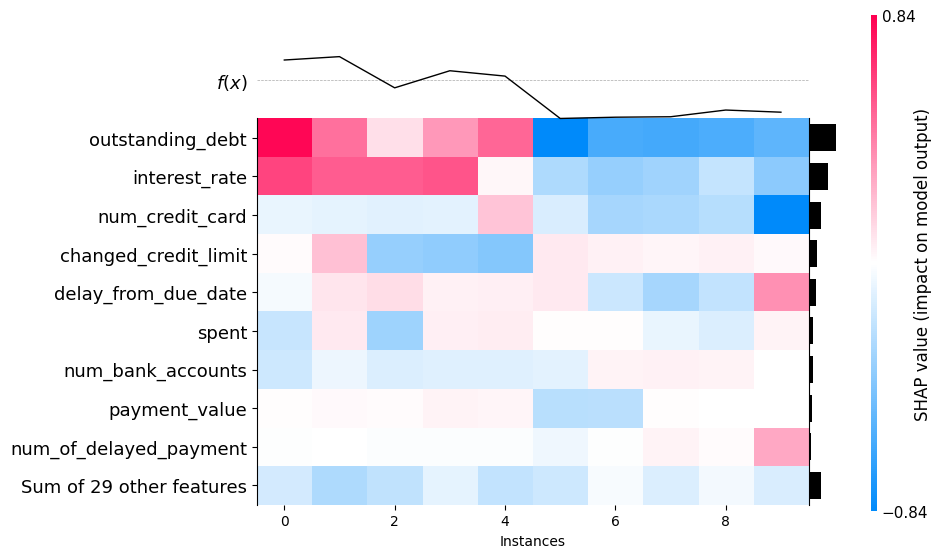

In [142]:
shap.plots.heatmap(shap.Explanation(
          values = shap_values[1][samples],
          base_values = explainer.expected_value[1],
          data = x_trans.iloc[samples],
          feature_names = x_trans.columns.tolist()
      ), max_display=10)

#### Análisis

Del análisis de los shap values se encontraron las características más y menos relevantes en el modelamiento, en particular se encontró que el modelamiento está fuertemente influenciado por la variable `outstanding_debt`. Si bien la importancia de esta variable tiene sentido, es posible que esto a su vez sea un indicio de que, o bien el resto de variables no son suficientemente útiles, o la variable `outstanding_debt` está sesgando demasiado al modelo.



### 7. Conclusiones






En general los resultados de clasificación aún dejan que desear, pues un 0.63 de F1 en el conjunto de prueba para la clase positiva indica que aún hay un gran margen de mejora, y que los modelos probablemente no sean suficientemente útiles para Giturra. Aún así, fue posible mejorar el resultado del baseline gracias a la busqueda en grilla, pasando de un F1 de 0.59 a uno de 0.63 para la clase positiva.

Si bien los resultados obtenidos no son completamente satisfactorios, del trabajo realizado se lograron identificar problemas en el dataset base (outliers, valores negativos y/o extraños) que podrían ser tratados de una forma más útil en una iteración futura. Por ejemplo, se podrían tratar los outliers de forma distinta (eliminarlos, reemplazarlos por valores extremos más acotados, etc). A su vez, se podrían añadir características más útiles en base a las ya existentes, o eliminar las que no son tan útiles, por ejemplo, la variable `occupation` podría eliminarse o tratarse como binaria (se especifica o no).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>